In [165]:
#Receiver Operating Characteristic (ROC) with cross validation
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
#统计模型
import statsmodels.api as sm

from sklearn import svm
#用来显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']
#用来正常显示负号
plt.rcParams['axes.unicode_minus']=False

import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

In [166]:
#加载数据
df = pd.read_excel('去除重复数据眼底和临床.xlsx',sheet_name="眼底和临床清洗")
# df2= pd.read_csv('finalScore.csv')
#祛除重复数据
df = df.drop_duplicates()
#包含有101个Nan
print(df.isnull().sum().sum())
#将Nan替换为各列的均值，否则建模时报错
df = df.fillna(df.mean())

1666


C:\Users\count\AppData\Local\Temp\ipykernel_12400\3970251911.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())


In [167]:
#临床资料
df1 = df[['*肌酐(酶法)','gender','总胆固醇','空腹血糖','age','吸烟状态1从不吸烟2目前吸烟3已戒烟','体重kg','身高cm','y']]
df1 = df1.drop_duplicates()
# df1.info()
df1.describe()

,*肌酐(酶法),gender,总胆固醇,空腹血糖,age,吸烟状态1从不吸烟2目前吸烟3已戒烟,体重kg,身高cm,y
count,1420.000000,1420.00000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000
mean,68.494608,1.46897,4.188203,6.280043,61.852609,0.459097,71.490291,164.276050,22.849356
std,18.723230,0.49886,1.146402,1.791998,10.289543,0.498149,11.859433,9.254639,31.542403
min,27.000000,1.00000,1.540000,2.100000,24.000000,0.000000,40.000000,1.000000,0.000000
25%,56.000000,1.00000,3.357500,5.200000,56.000000,0.000000,65.000000,159.000000,0.000000
50%,67.000000,1.00000,4.000000,5.800000,62.000000,0.000000,71.490291,164.276050,10.000000
75%,78.000000,2.00000,4.832500,6.800000,69.000000,1.000000,78.250000,170.000000,32.000000
max,228.000000,2.00000,10.600000,19.100000,90.000000,1.000000,150.000000,190.000000,296.000000


In [168]:
from sklearn.preprocessing import Binarizer
# help(Binarizer)
# reshape(-1,1)的意思是 请帮我将数据规整为任意行（-1)，1列,这是对列进行增维，类为特征专用，不能使用一维数据
df1_0 = df1.iloc[:,-1].values.reshape(-1,1)
# print(df1_0)
# print(df1.iloc[:,-1].values)
binarizer = Binarizer(threshold = 4).fit_transform(df1_0)#thresold阈值
df1.loc[:,"y"] = binarizer
df1.describe()

,*肌酐(酶法),gender,总胆固醇,空腹血糖,age,吸烟状态1从不吸烟2目前吸烟3已戒烟,体重kg,身高cm,y
count,1420.000000,1420.00000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000,1420.000000
mean,68.494608,1.46897,4.188203,6.280043,61.852609,0.459097,71.490291,164.276050,0.638028
std,18.723230,0.49886,1.146402,1.791998,10.289543,0.498149,11.859433,9.254639,0.480740
min,27.000000,1.00000,1.540000,2.100000,24.000000,0.000000,40.000000,1.000000,0.000000
25%,56.000000,1.00000,3.357500,5.200000,56.000000,0.000000,65.000000,159.000000,0.000000
50%,67.000000,1.00000,4.000000,5.800000,62.000000,0.000000,71.490291,164.276050,1.000000
75%,78.000000,2.00000,4.832500,6.800000,69.000000,1.000000,78.250000,170.000000,1.000000
max,228.000000,2.00000,10.600000,19.100000,90.000000,1.000000,150.000000,190.000000,1.000000


In [169]:
#划分特征变量和目标变量
X = df1.drop(columns="y")
y = df1["y"]

In [170]:
#两类数据是否均衡
# category_counts = df1['y'].value_counts()
# print(category_counts)
df1['y'].value_counts()

1.0    906
0.0    514
Name: y, dtype: int64

In [171]:
n_samples, n_features = X.shape
print(n_samples)
# n_features
# X.shape
#add noisy features to make the problem harder.
random_state = np.random.RandomState(42)
# X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)

1420


In [172]:
# 计算95%置信区间
def calculate_confidence_interval(scores):
    mean = np.mean(scores)
    std = np.std(scores)
    n = len(scores)
    z = 1.96  # 95% 置信水平的Z值
    lower_bound = mean - (z * std / np.sqrt(n))
    upper_bound = mean + (z * std / np.sqrt(n))
    return lower_bound, upper_bound

Fold 0:
  Train indices: (1136,)
  Test indices: (284,)
Fold 1:
  Train indices: (1136,)
  Test indices: (284,)
Fold 2:
  Train indices: (1136,)
  Test indices: (284,)
Fold 3:
  Train indices: (1136,)
  Test indices: (284,)


d:\programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Fold 4:
  Train indices: (1136,)
  Test indices: (284,)


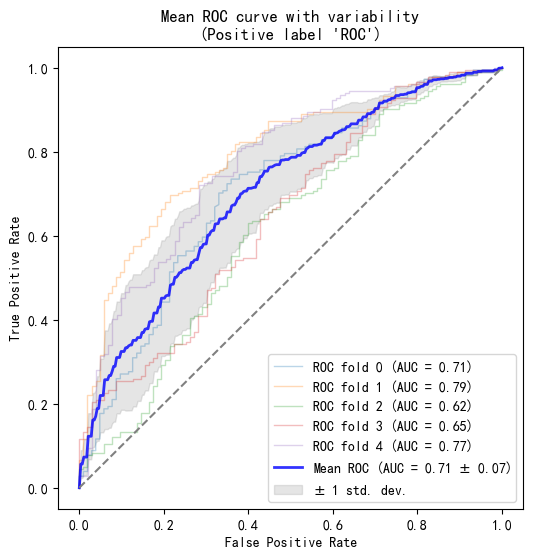

AUC 95% 置信区间: (0.6466001359694141, 0.7670643409577288)
准确率 95% 置信区间: (0.65430664820836, 0.7259750419324852)
特异度 95% 置信区间: (0.3295192413180623, 0.4646555159634911)
灵敏度 95% 置信区间: (0.8241683568117631, 0.8888181042409963)


In [173]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)
# classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
classifier = LogisticRegression()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 284)
# 计算特异度和灵敏度
specificity_scores = []
sensitivity_scores = []
accuracy_scores = []
auc_scores = []

tpr_list = []
fpr_list = []

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    #查看每个folder样本数是否一致
    print(f"Fold {fold}:")
    print(f"  Train indices: {train.shape}")
    print(f"  Test indices: {test.shape}")
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    classifier.fit(X_train, y_train)


    # classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        # plot_chance_level=(fold == n_splits - 1),
        # plot_chance_level= 4,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    #计算confidence interval
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)

    auc_scores.append(roc_auc_score(y_test, y_pred_proba))
    accuracy_scores.append(accuracy_score(y_test, y_pred))


    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, drop_intermediate=False)#drop_intermediate=False 不省略数值
    tpr_list.append(tpr)
    fpr_list.append(fpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'ROC')",
)
ax.legend(loc="lower right")
#加上平均线
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.show()
#confidence interval
auc_ci = calculate_confidence_interval(auc_scores)
accuracy_ci = calculate_confidence_interval(accuracy_scores)
specificity_ci = calculate_confidence_interval(specificity_scores)
sensitivity_ci = calculate_confidence_interval(sensitivity_scores)

print("AUC 95% 置信区间:", auc_ci) 
print("准确率 95% 置信区间:", accuracy_ci)
print("特异度 95% 置信区间:", specificity_ci)
print("灵敏度 95% 置信区间:", sensitivity_ci)

In [174]:
#眼底资料
df2 = df[['颞上动静脉管径比','颞上CRAE','颞上CRVE','动脉分形维数','静脉分形维数','动脉弯曲度','静脉弯曲度','y']]
# df2 = df[['颞上动静脉管径比','颞上CRAE','动脉分形维数','静脉分形维数','动脉弯曲度','y']]
# AUC 0.57
df2 = df2.drop_duplicates()
# df2.info()
df2.describe()
#二值化
from sklearn.preprocessing import Binarizer
# help(Binarizer)
# reshape(-1,1)的意思是 请帮我将数据规整为任意行（-1)，1列,这是对列进行增维，类为特征专用，不能使用一维数据
df2_0 = df2.iloc[:,-1].values.reshape(-1,1)
# print(df2_0)
# print(df2.iloc[:,-1].values)
binarizer = Binarizer(threshold = 4).fit_transform(df2_0)#thresold阈值
df2.loc[:,"y"] = binarizer
df2.describe()
#划分特征变量和目标变量
X = df2.drop(columns="y")
y = df2["y"]

Fold 0:
  Train indices: (1136,)
  Test indices: (284,)
Fold 1:
  Train indices: (1136,)
  Test indices: (284,)
Fold 2:
  Train indices: (1136,)
  Test indices: (284,)


d:\programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Fold 3:
  Train indices: (1136,)
  Test indices: (284,)
Fold 4:
  Train indices: (1136,)
  Test indices: (284,)


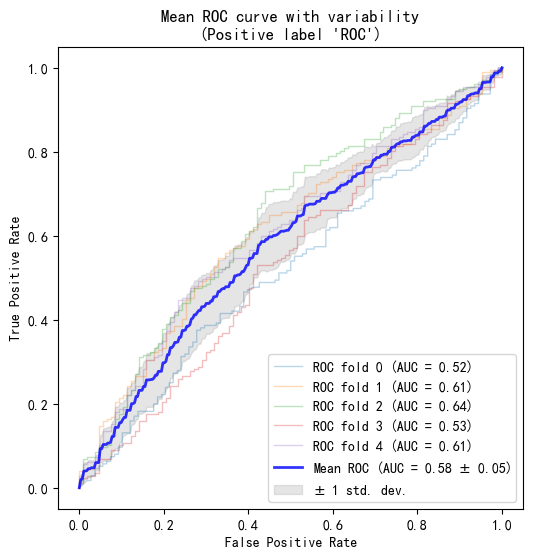

AUC 95% 置信区间: (0.5399096543911279, 0.6233678984486379)
准确率 95% 置信区间: (0.6058507243872442, 0.6251351911057135)
特异度 95% 置信区间: (0.006609381051801545, 0.023193318844356298)
灵敏度 95% 置信区间: (0.9627404468852893, 0.9964531843422401)


In [175]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

random_state = np.random.RandomState(0)
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)
# classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
classifier = LogisticRegression()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 284)

# 计算特异度和灵敏度
specificity_scores = []
sensitivity_scores = []
accuracy_scores = []
auc_scores = []

tpr_list = []
fpr_list = []

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    #查看每个folder样本数是否一致
    print(f"Fold {fold}:")
    print(f"  Train indices: {train.shape}")
    print(f"  Test indices: {test.shape}")
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    classifier.fit(X_train, y_train)


    # classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        #plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    #计算confidence interval
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)

    auc_scores.append(roc_auc_score(y_test, y_pred_proba))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'ROC')",
)
ax.legend(loc="lower right")
plt.show()

#confidence interval
auc_ci = calculate_confidence_interval(auc_scores)
accuracy_ci = calculate_confidence_interval(accuracy_scores)
specificity_ci = calculate_confidence_interval(specificity_scores)
sensitivity_ci = calculate_confidence_interval(sensitivity_scores)

print("AUC 95% 置信区间:", auc_ci) 
print("准确率 95% 置信区间:", accuracy_ci)
print("特异度 95% 置信区间:", specificity_ci)
print("灵敏度 95% 置信区间:", sensitivity_ci)

In [176]:
#临床和眼底资料
# df3 = df[['*肌酐(酶法)','gender','总胆固醇','空腹血糖','age', 'y']]
#临床+'颞上动静脉管径比',或'颞上CRAE'均为0.7 ，加'颞上CRVE'0.71 '动脉分形维数'为0.70'静脉分形维数'0.70动脉弯曲度'0.7静脉弯曲度'0.7
# df3 = df[['*肌酐(酶法)','gender','总胆固醇','空腹血糖','age','颞上动静脉管径比','颞上CRAE','颞上CRVE','动脉分形维数','静脉分形维数','动脉弯曲度','静脉弯曲度','y']]

# df3 = df[['*肌酐(酶法)','gender','总胆固醇','空腹血糖','age','颞上动静脉管径比','颞上CRAE','颞上CRVE','动脉分形维数','静脉分形维数','动脉弯曲度','静脉弯曲度','y']]
#AUC 0.70
# df3= df[['*肌酐(酶法)','gender','总胆固醇','空腹血糖','age','吸烟状态1从不吸烟2目前吸烟3已戒烟','体重kg','身高cm','颞上动静脉管径比','颞上CRAE','颞上动静脉管径比','颞上CRAE','颞上CRVE','动脉分形维数','静脉分形维数','动脉弯曲度','静脉弯曲度','动脉分形维数','静脉分形维数','y']]
# auc 0.70
df3= df[['*肌酐(酶法)','gender','总胆固醇','空腹血糖','age','吸烟状态1从不吸烟2目前吸烟3已戒烟','体重kg','身高cm','颞上动静脉管径比','颞上CRAE','颞上动静脉管径比','y']]

df3 = df3.drop_duplicates()
# df2.info()
# df3.describe()
#二值化
from sklearn.preprocessing import Binarizer
# help(Binarizer)
# reshape(-1,1)的意思是 请帮我将数据规整为任意行（-1)，1列,这是对列进行增维，类为特征专用，不能使用一维数据
df3_0 = df3.iloc[:,-1].values.reshape(-1,1)
# print(df2_0)
# print(df2.iloc[:,-1].values)
binarizer = Binarizer(threshold = 4).fit_transform(df3_0)#thresold阈值
df3.loc[:,"y"] = binarizer
df3.describe()
#划分特征变量和目标变量
X = df3.drop(columns="y")
y = df3["y"]

Fold 0:
  Train indices: (1156,)
  Test indices: (289,)
Fold 1:
  Train indices: (1156,)
  Test indices: (289,)


d:\programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Fold 2:
  Train indices: (1156,)
  Test indices: (289,)
Fold 3:
  Train indices: (1156,)
  Test indices: (289,)
Fold 4:
  Train indices: (1156,)
  Test indices: (289,)


d:\programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\programs\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

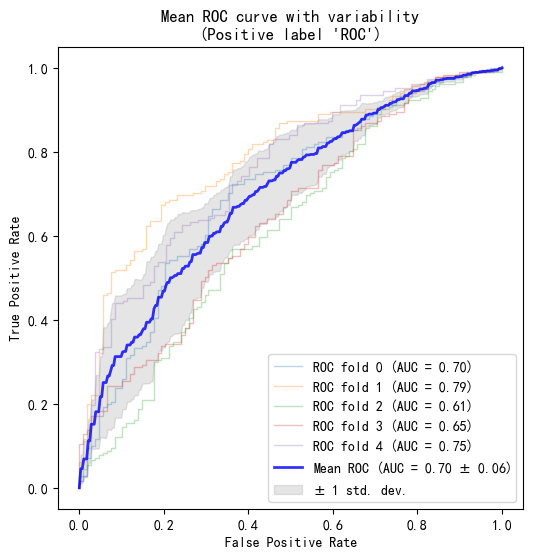

AUC 95% 置信区间: (0.6449735188056264, 0.7569447356659406)
准确率 95% 置信区间: (0.6454779479026199, 0.710923436180425)
特异度 95% 置信区间: (0.3332757409632641, 0.4499364431834995)
灵敏度 95% 置信区间: (0.8182812383635395, 0.8792477519831304)


In [177]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

random_state = np.random.RandomState(0)
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)
# classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
classifier = LogisticRegression()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 284)

# 计算特异度和灵敏度
specificity_scores = []
sensitivity_scores = []
accuracy_scores = []
auc_scores = []

tpr_list = []
fpr_list = []

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    #查看每个folder样本数是否一致
    print(f"Fold {fold}:")
    print(f"  Train indices: {train.shape}")
    print(f"  Test indices: {test.shape}")
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    classifier.fit(X_train, y_train)


    # classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        #plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    #计算confidence interval
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)

    auc_scores.append(roc_auc_score(y_test, y_pred_proba))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'ROC')",
)
ax.legend(loc="lower right")
plt.show()

#confidence interval
auc_ci = calculate_confidence_interval(auc_scores)
accuracy_ci = calculate_confidence_interval(accuracy_scores)
specificity_ci = calculate_confidence_interval(specificity_scores)
sensitivity_ci = calculate_confidence_interval(sensitivity_scores)

print("AUC 95% 置信区间:", auc_ci) 
print("准确率 95% 置信区间:", accuracy_ci)
print("特异度 95% 置信区间:", specificity_ci)
print("灵敏度 95% 置信区间:", sensitivity_ci)

In [178]:
#女性
#临床和眼底资料
df4 = df.loc[df["gender"] == 1]
# df5= df4[['*肌酐(酶法)','总胆固醇','空腹血糖','age','吸烟状态1从不吸烟2目前吸烟3已戒烟','体重kg','身高cm','颞上动静脉管径比','颞上CRAE','颞上动静脉管径比','颞上CRAE','颞上CRVE','动脉分形维数','静脉分形维数','动脉弯曲度','静脉弯曲度','动脉分形维数','静脉分形维数','y']]
# auc 
df5= df4[['*肌酐(酶法)','总胆固醇','空腹血糖','age','吸烟状态1从不吸烟2目前吸烟3已戒烟','体重kg','身高cm','y']]
# auc 
# df3= df[['*肌酐(酶法)','gender','总胆固醇','空腹血糖','age','吸烟状态1从不吸烟2目前吸烟3已戒烟','体重kg','身高cm','颞上动静脉管径比','颞上CRAE','颞上动静脉管径比','y']]

df5 = df5.drop_duplicates()
# df2.info()
# df3.describe()
#二值化
from sklearn.preprocessing import Binarizer
# help(Binarizer)
# reshape(-1,1)的意思是 请帮我将数据规整为任意行（-1)，1列,这是对列进行增维，类为特征专用，不能使用一维数据
df5_0 = df5.iloc[:,-1].values.reshape(-1,1)
# print(df2_0)
# print(df2.iloc[:,-1].values)
binarizer = Binarizer(threshold = 4).fit_transform(df5_0)#thresold阈值
df5.loc[:,"y"] = binarizer
df5.describe()
#划分特征变量和目标变量
X = df5.drop(columns="y")
y = df5["y"]

In [179]:
df5

,*肌酐(酶法),总胆固醇,空腹血糖,age,吸烟状态1从不吸烟2目前吸烟3已戒烟,体重kg,身高cm,y
0,65.0,8.48,5.4,39.0,0.0,80.000000,178.00000,0.0
2,91.0,3.18,5.9,71.0,0.0,77.000000,168.00000,1.0
3,60.0,5.40,6.9,69.0,1.0,71.490291,164.27605,1.0
4,70.0,3.88,7.7,51.0,1.0,80.000000,165.00000,1.0
6,70.0,3.45,6.0,44.0,0.0,105.000000,178.00000,0.0
...,...,...,...,...,...,...,...,...
1470,65.0,3.64,7.7,76.0,1.0,72.000000,172.00000,1.0
1471,80.0,3.68,5.6,59.0,1.0,77.000000,170.00000,0.0
1472,68.0,3.72,7.6,74.0,0.0,80.000000,170.00000,1.0
1476,69.0,5.27,4.6,49.0,1.0,88.000000,170.00000,0.0


Fold 0:
  Train indices: (602,)
  Test indices: (151,)
Fold 1:
  Train indices: (602,)
  Test indices: (151,)
Fold 2:
  Train indices: (602,)
  Test indices: (151,)
Fold 3:
  Train indices: (603,)
  Test indices: (150,)
Fold 4:
  Train indices: (603,)
  Test indices: (150,)


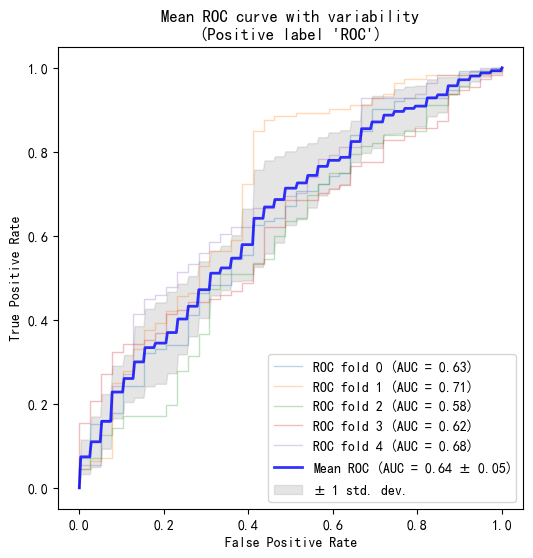

AUC 95% 置信区间: (0.6025828202909185, 0.6818997391916408)
准确率 95% 置信区间: (0.726322394651676, 0.7504281572247037)
特异度 95% 置信区间: (0.04977361614953588, 0.0938161274402077)
灵敏度 95% 置信区间: (0.9560189871095551, 0.9865807554901874)


In [180]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

random_state = np.random.RandomState(0)
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)
# classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)
classifier = LogisticRegression()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 284)

# 计算特异度和灵敏度
specificity_scores = []
sensitivity_scores = []
accuracy_scores = []
auc_scores = []

tpr_list = []
fpr_list = []

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    #查看每个folder样本数是否一致
    print(f"Fold {fold}:")
    print(f"  Train indices: {train.shape}")
    print(f"  Test indices: {test.shape}")
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    classifier.fit(X_train, y_train)


    # classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        #plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    #计算confidence interval
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)

    auc_scores.append(roc_auc_score(y_test, y_pred_proba))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'ROC')",
)
ax.legend(loc="lower right")
plt.show()

#confidence interval
auc_ci = calculate_confidence_interval(auc_scores)
accuracy_ci = calculate_confidence_interval(accuracy_scores)
specificity_ci = calculate_confidence_interval(specificity_scores)
sensitivity_ci = calculate_confidence_interval(sensitivity_scores)

print("AUC 95% 置信区间:", auc_ci) 
print("准确率 95% 置信区间:", accuracy_ci)
print("特异度 95% 置信区间:", specificity_ci)
print("灵敏度 95% 置信区间:", sensitivity_ci)